In [1]:
# Random Imports
import os
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

# Regular schema dictates that we put DATAPATH
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))
os.environ['WANDB_NOTEBOOK_NAME'] = 'train.ipynb'

%load_ext yamlmagic
%load_ext autoreload
%autoreload 2

## Define said jobs

In [2]:
%%yaml default_cfg 

experiment:
  seed: 42
    
dataloader:
  batch_size: 1 
  num_workers: 2 
  pin_memory: False 

optim: 
  _class: torch.optim.Adam
  lr: 3.0e-4
  weight_decay: 0.0 
  
# For MultiClass
train:
  epochs: 100 
  eval_freq: 5
  augmentations: None

log:
  checkpoint_freq: 5 
  root: '?'
  metrics:
    dice_score:
      _fn: ionpy.metrics.dice_score
      from_logits: True
      batch_reduction: 'mean' 
      ignore_index: 0

loss_func: 
  _class: ionpy.loss.SoftDiceLoss
  from_logits: True
  batch_reduction: 'mean' 
  ignore_index: 0 # Make sure to ignore the background class

# For Binary

# train:
#   epochs: 500 
#   eval_freq: 50

# log:
#   checkpoint_freq: 50 
#   root: '?'
#   metrics:
#     dice_score:
#       _fn: ionpy.metrics.dice_score
#       from_logits: True
#       batch_reduction: 'mean' 

# loss_func: 
#   _class: ionpy.loss.SoftDiceLoss
#   from_logits: True
#   batch_reduction: 'mean' 

<IPython.core.display.Javascript object>

In [3]:
%%yaml model_cfg  

model:
  _class: ese.experiment.models.UNet
  filters: '?'
  convs_per_block: 3

<IPython.core.display.Javascript object>

In [4]:
%%yaml dataset_cfg 

# data:
#   _class: ese.experiment.datasets.WMH
#   annotator: observer_o12
#   axis: 0
#   preload: False 
#   num_slices: 1
#   task: Amsterdam 
#   version: 0.2
#   in_channels: 1
#   out_channels: 2 

# data:
#   _class: ese.experiment.datasets.COCO 
#   in_channels: 3
#   out_channels: 80

data:
  _class: ese.experiment.datasets.OxfordPets
  preload: True
  version: 0.1
  skip_classes: ["Egyptian_Mau"]
  in_channels: 3
  out_channels: 2

<IPython.core.display.Javascript object>

In [5]:
# %%yaml lite_aug_cfg

# - RandomAffine:
#     p: 0.5
#     degrees: [0, 360]
#     translate: [0, 0.2]
#     scale: [0.8, 1.1]
# - RandomVariableElasticTransform:
#     p: 0.75
#     alpha: [1, 2] 
#     sigma: [7, 9]
# - RandomHorizontalFlip:
#     p: 0.5
# - RandomVerticalFlip:
#     p: 0.5

In [6]:
%%yaml standard_aug_cfg 

- RandomCrop:
    _class: ese.experiment.augmentation.transforms.RandomCropSegmentation
    size: [256, 256]

<IPython.core.display.Javascript object>

In [7]:
%%yaml callbacks_cfg

callbacks:
  step:
    - ese.experiment.callbacks.ShowPredictions:
        mode: multiclass
        label_cmap: tab10 
  epoch:
    - ese.experiment.callbacks.WandbLogger
    - ionpy.callbacks.ETA
    - ionpy.callbacks.JobProgress
    - ionpy.callbacks.TerminateOnNaN
    - ionpy.callbacks.PrintLogged
    - ionpy.callbacks.ModelCheckpoint:
        monitor: dice_score
        phase: val

<IPython.core.display.Javascript object>

## Debug Station

In [8]:
# Need to define the experiment name
# exp_name = 'COCO_runs'
exp_name = 'debug'

# Create the ablation options
option_set = [
    {
        'log.root': [f'/storage/vbutoi/scratch/ESE/{exp_name}'],
        # 'augmentations': [standard_aug_cfg],
        'dataloader.batch_size': [1],
        'optim.lr': [3.0e-4],
        'model.filters': [[128, 128, 128, 128, 128]]
    },
]

In [9]:
from ese.scripts.utils import get_option_product
from ionpy.util import Config


# Assemble base config
#base_cfg = Config(default_cfg).update(model_cfg).update(dataset_cfg).update(transforms_cfg).update(callbacks_cfg)
base_cfg = Config(default_cfg).update([model_cfg, dataset_cfg, callbacks_cfg])

# Get the configs
cfgs = get_option_product(exp_name, option_set, base_cfg)

In [10]:
len(cfgs)

1

## Running Jobs

In [11]:
# Submit cell
from ionpy import slite
from ese.experiment.experiment.ese_exp import CalibrationExperiment 

Running CalibrationExperiment("/storage/vbutoi/scratch/ESE/debug/20230915_110427-HA2R-ebdd5fd991b7120a4733c11a89d69bb6")
---
callbacks:
  epoch:
  - ese.experiment.callbacks.WandbLogger
  - ionpy.callbacks.ETA
  - ionpy.callbacks.JobProgress
  - ionpy.callbacks.TerminateOnNaN
  - ionpy.callbacks.PrintLogged
  - ionpy.callbacks.ModelCheckpoint:
      monitor: dice_score
      phase: val
  step:
  - ese.experiment.callbacks.ShowPredictions:
      label_cmap: tab10
      mode: multiclass
data:
  _class: ese.experiment.datasets.OxfordPets
  preload: true
  skip_classes:
  - Egyptian_Mau
  version: 0.1
dataloader:
  batch_size: 1
  num_workers: 2
  pin_memory: false
experiment:
  seed: 42
log:
  checkpoint_freq: 5
  metrics:
    dice_score:
      _fn: ionpy.metrics.dice_score
      batch_reduction: mean
      from_logits: true
  root: /storage/vbutoi/scratch/ESE/debug
  wandb_string: exp_name:debug-batch_size:1-lr:0.0003-filters:[128,128,128,128,128]
loss_func:
  _class: ionpy.loss.SoftDice

wandb: Currently logged in as: vbutoi. Use `wandb login --relogin` to force relogin


Start epoch 0
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.3699, device='cuda:0', grad_fn=<RsubBackward1>)


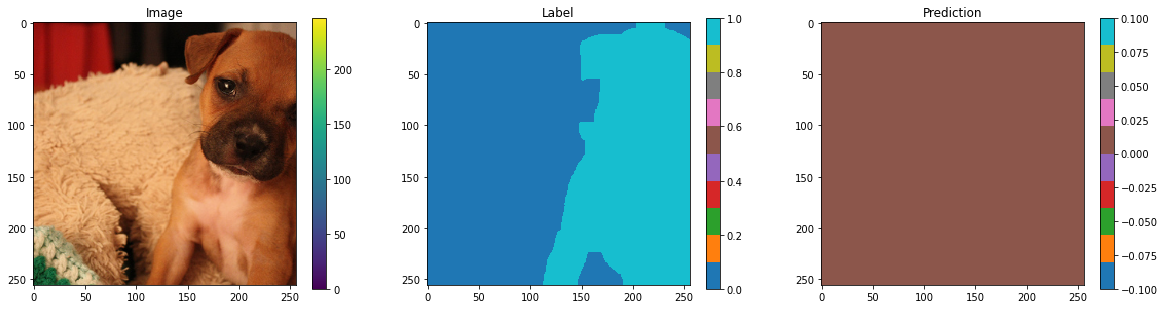

torch.float32
tensor(65522., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(27138., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.3758, device='cuda:0', grad_fn=<RsubBackward1>)


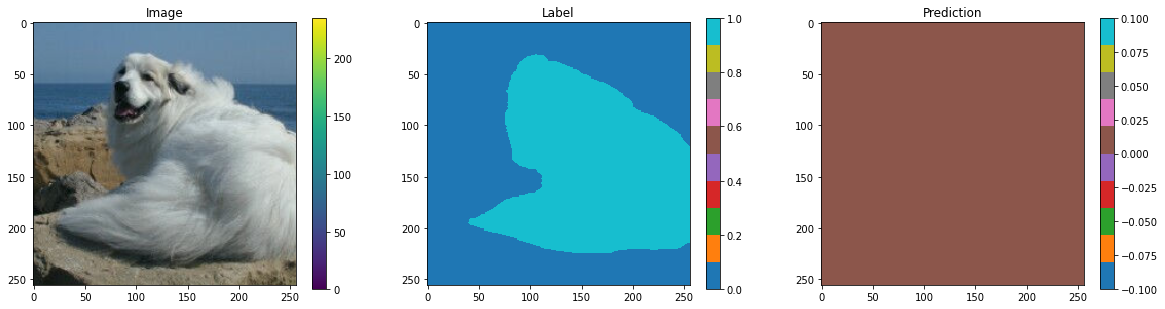

torch.float32
tensor(16943., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(27541., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.4076, device='cuda:0', grad_fn=<RsubBackward1>)


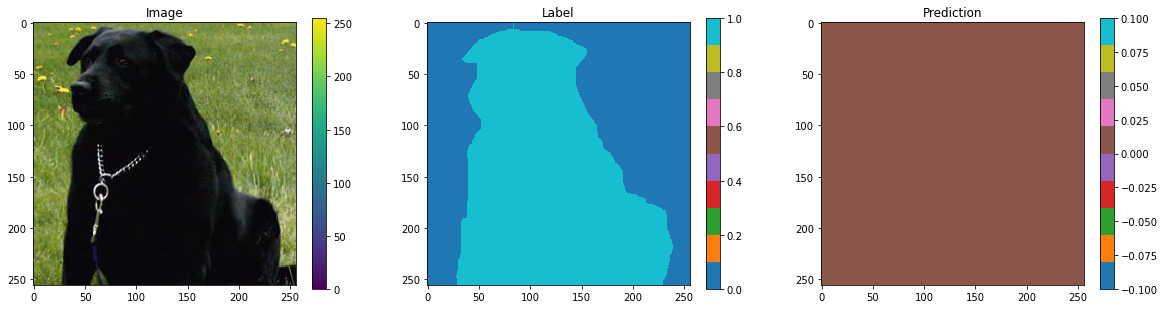

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(36278., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.3360, device='cuda:0', grad_fn=<RsubBackward1>)


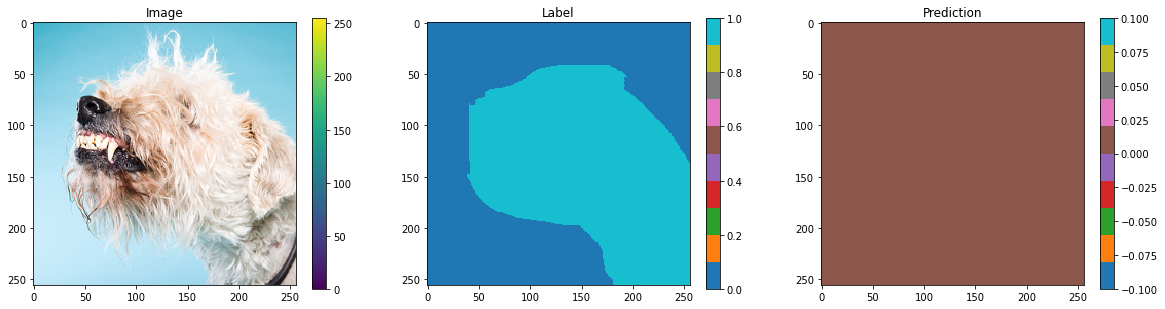

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(32541., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.3753, device='cuda:0', grad_fn=<RsubBackward1>)


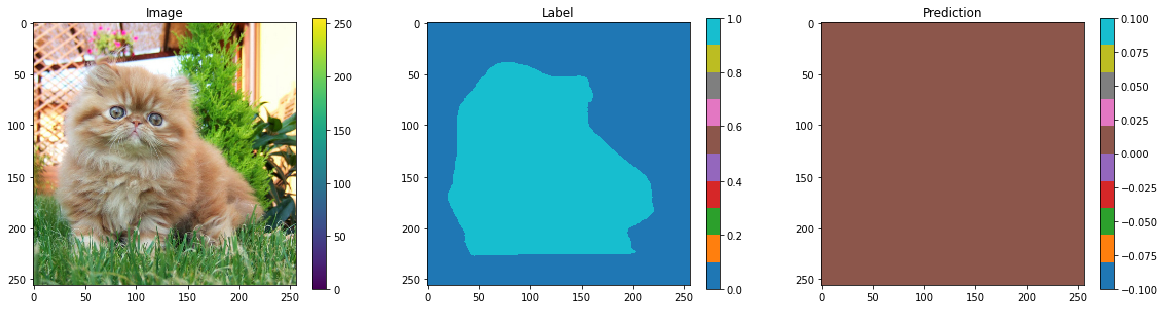

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(27826., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.7186, device='cuda:0', grad_fn=<RsubBackward1>)


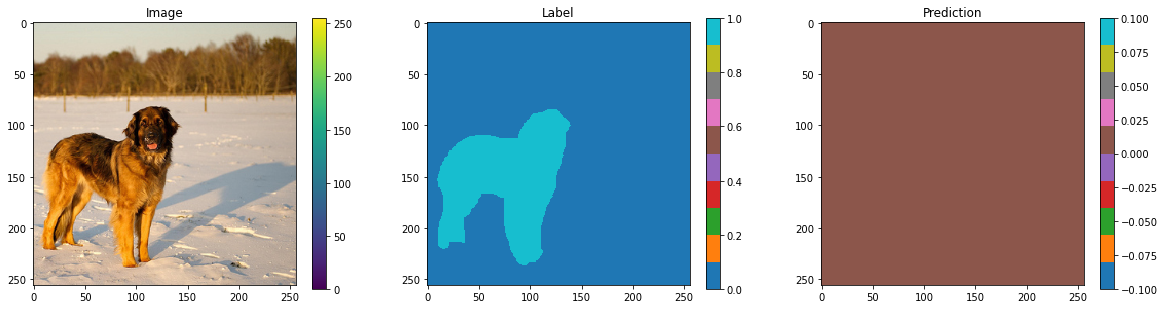

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(10993., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.7096, device='cuda:0', grad_fn=<RsubBackward1>)


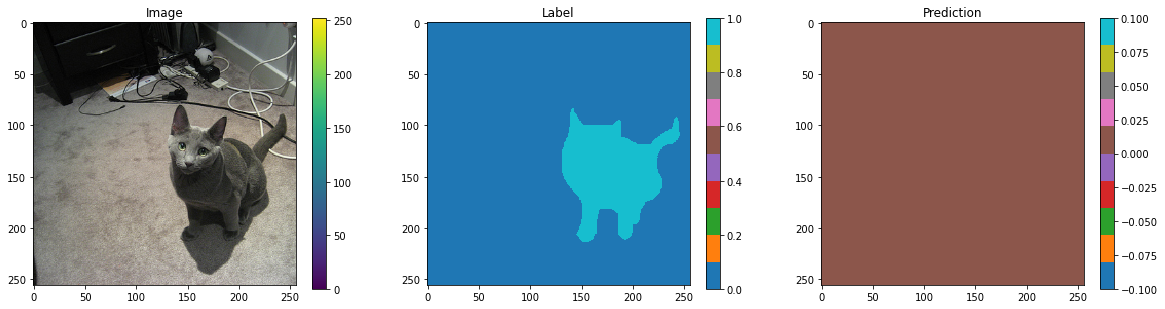

torch.float32
tensor(65535., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(8041., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.5701, device='cuda:0', grad_fn=<RsubBackward1>)


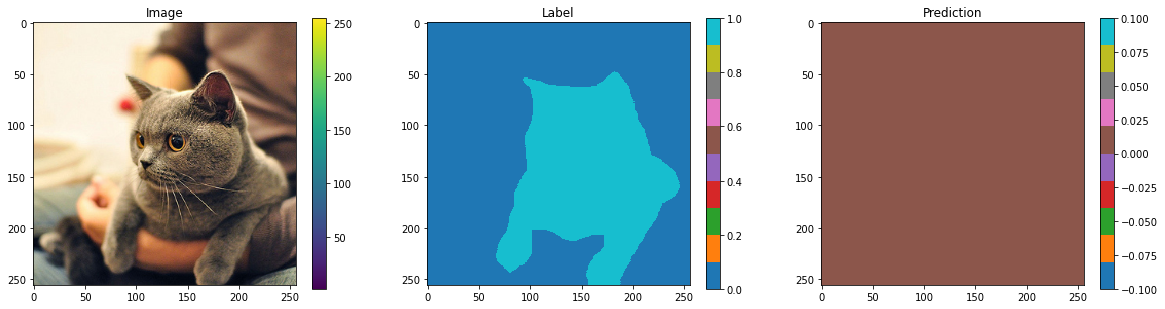

torch.float32
tensor(4., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(21654., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.5984, device='cuda:0', grad_fn=<RsubBackward1>)


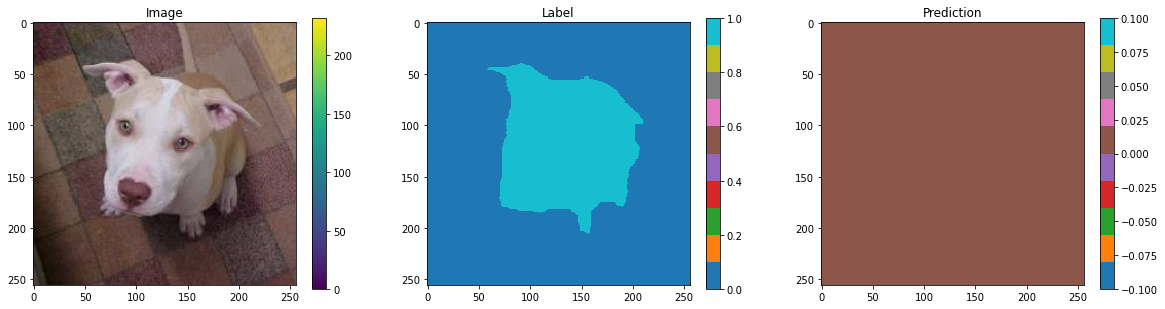

torch.float32
tensor(4., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(16099., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.5577, device='cuda:0', grad_fn=<RsubBackward1>)


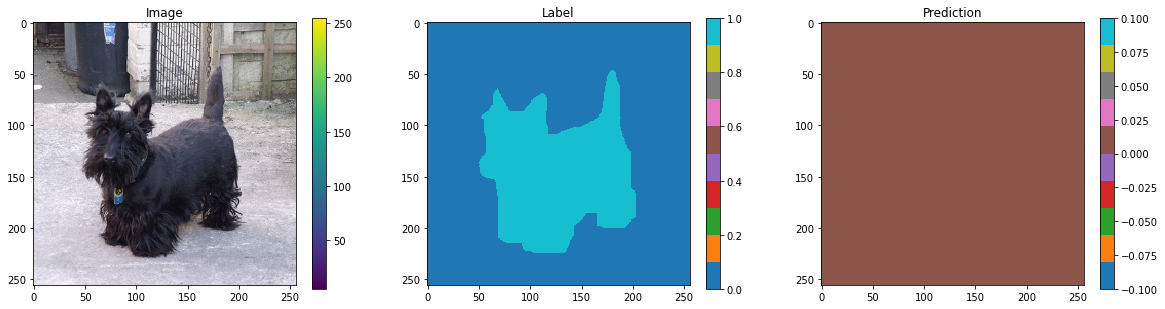

torch.float32
tensor(65525., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(16985., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.2918, device='cuda:0', grad_fn=<RsubBackward1>)


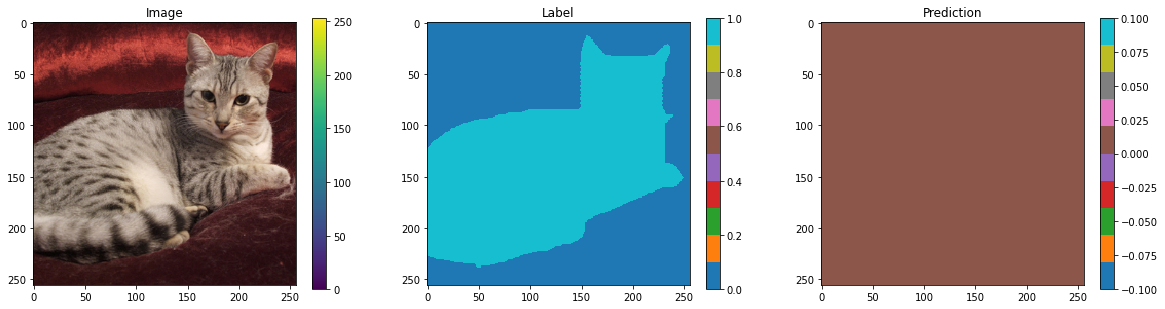

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(32822., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.2312, device='cuda:0', grad_fn=<RsubBackward1>)


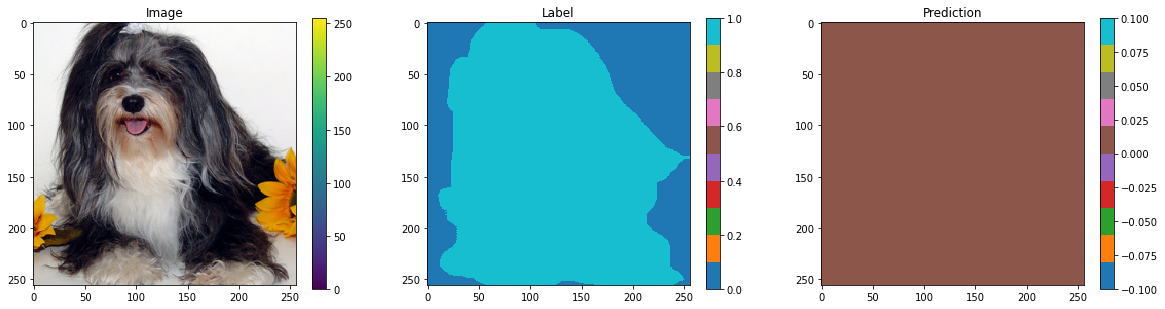

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(46671., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.4196, device='cuda:0', grad_fn=<RsubBackward1>)


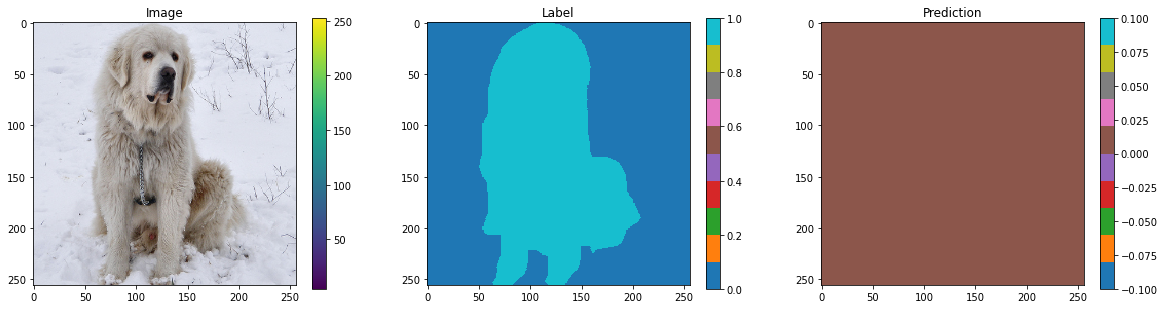

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(26009., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.3539, device='cuda:0', grad_fn=<RsubBackward1>)


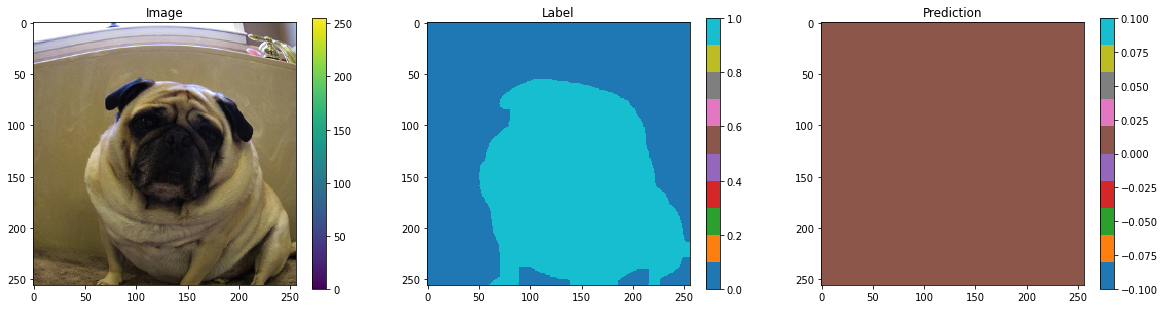

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(30434., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.2498, device='cuda:0', grad_fn=<RsubBackward1>)


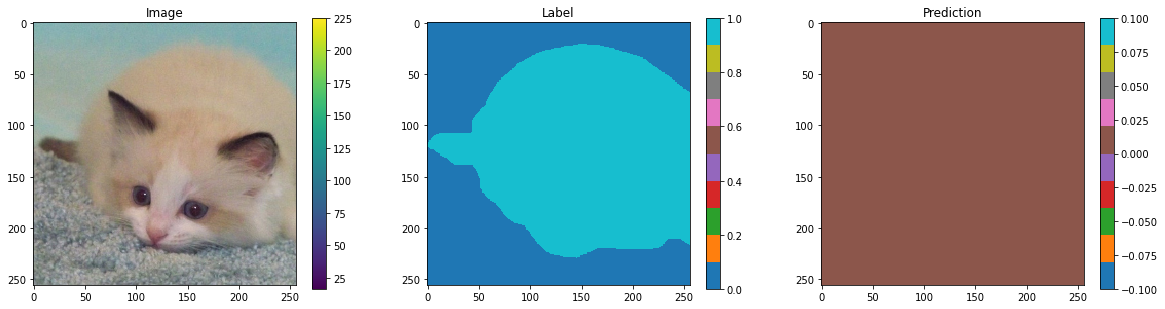

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(36974., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.3805, device='cuda:0', grad_fn=<RsubBackward1>)


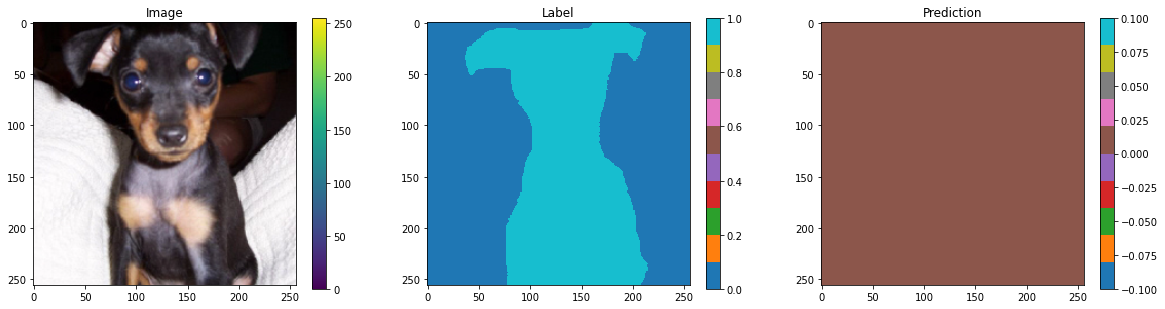

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(27649., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.2802, device='cuda:0', grad_fn=<RsubBackward1>)


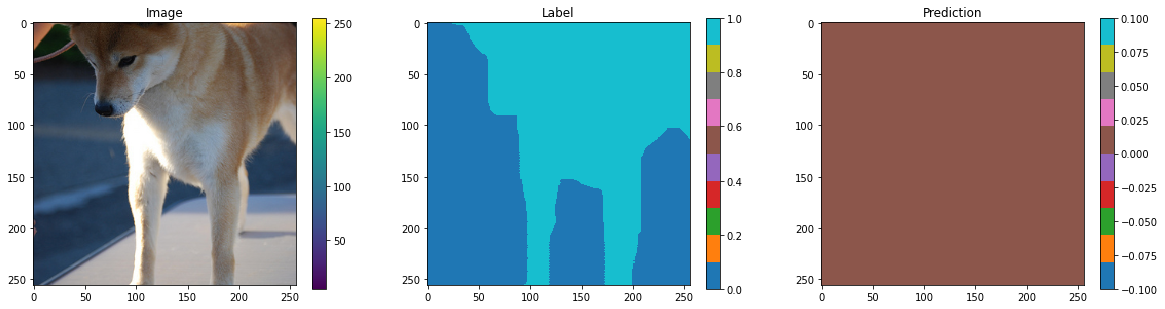

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(33119., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.1182, device='cuda:0', grad_fn=<RsubBackward1>)


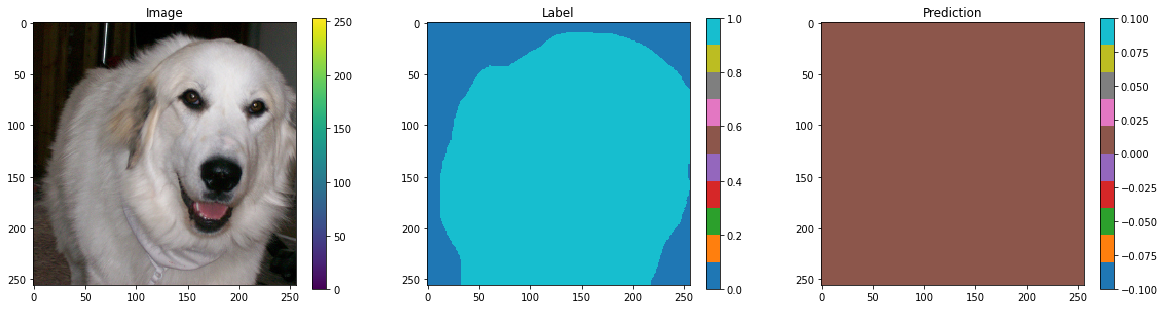

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(50703., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.4227, device='cuda:0', grad_fn=<RsubBackward1>)


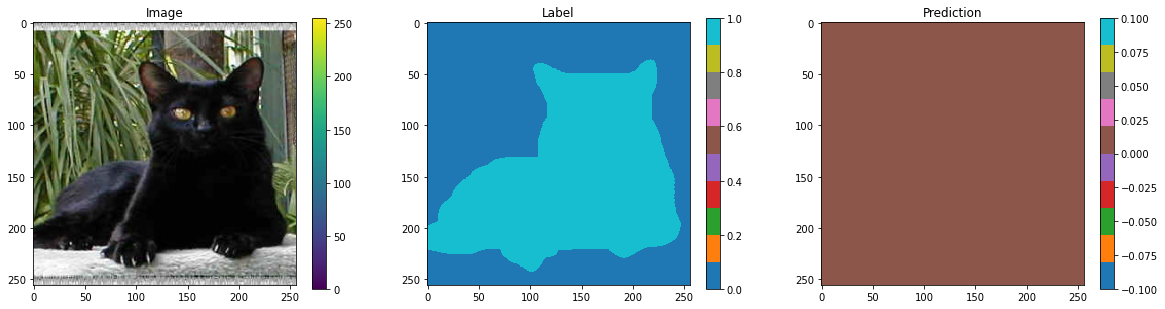

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(30270., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.5714, device='cuda:0', grad_fn=<RsubBackward1>)


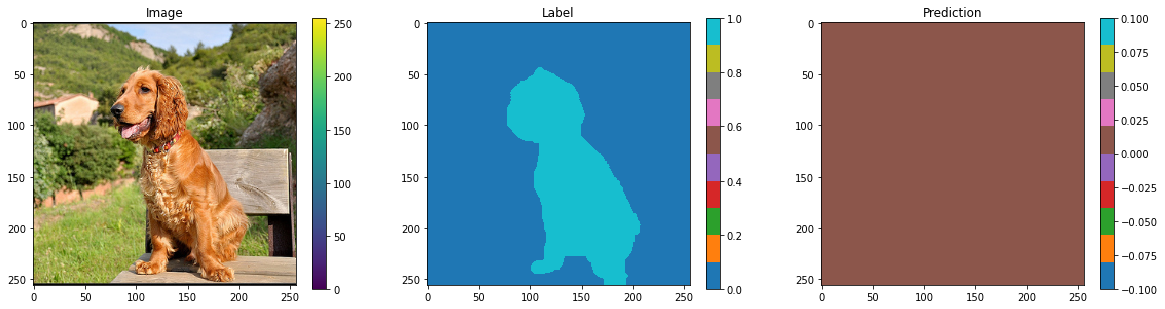

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(14444., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.3284, device='cuda:0', grad_fn=<RsubBackward1>)


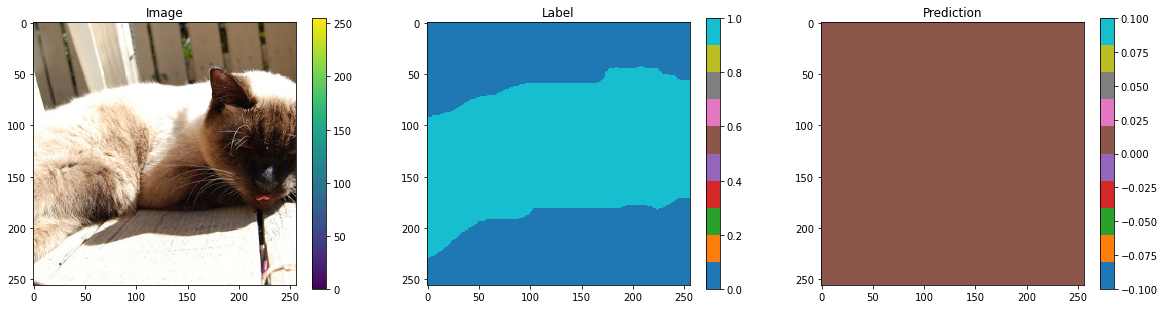

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(32433., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.6052, device='cuda:0', grad_fn=<RsubBackward1>)


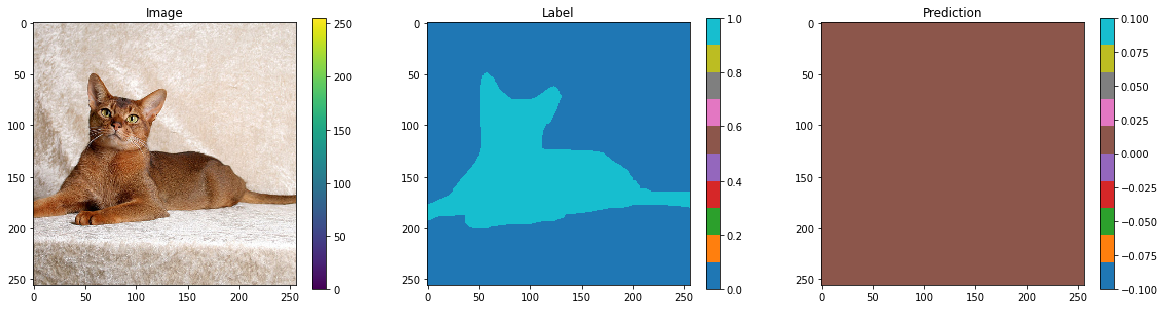

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(15941., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.2572, device='cuda:0', grad_fn=<RsubBackward1>)


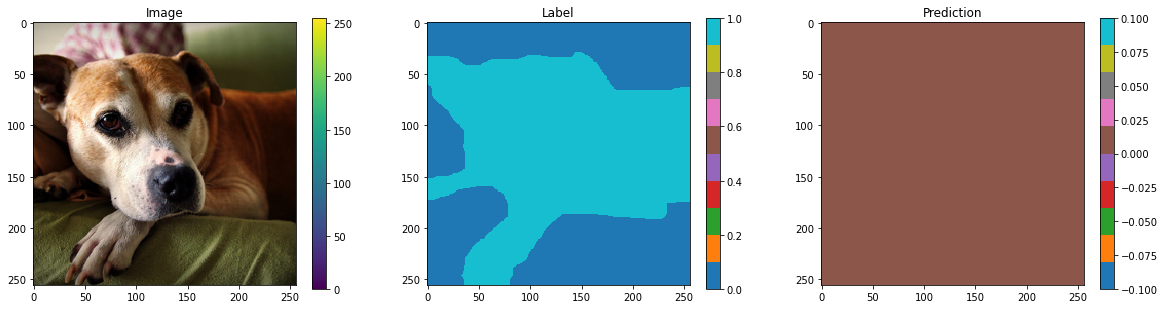

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(35959., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.6892, device='cuda:0', grad_fn=<RsubBackward1>)


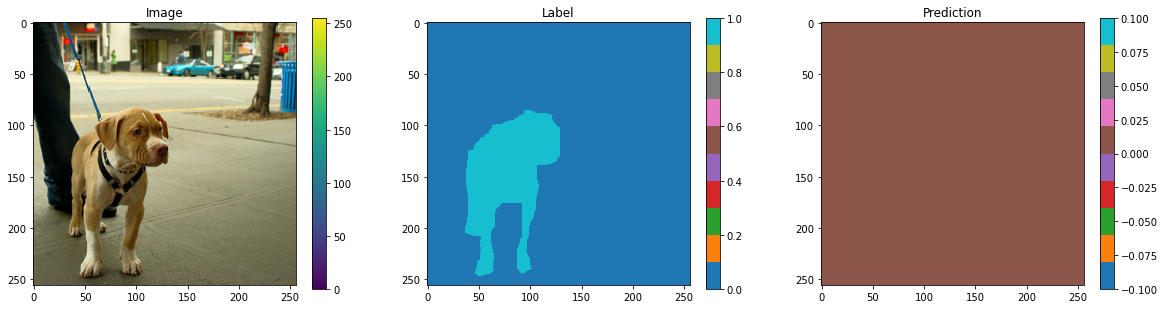

torch.float32
tensor(65507., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(8099., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.2868, device='cuda:0', grad_fn=<RsubBackward1>)


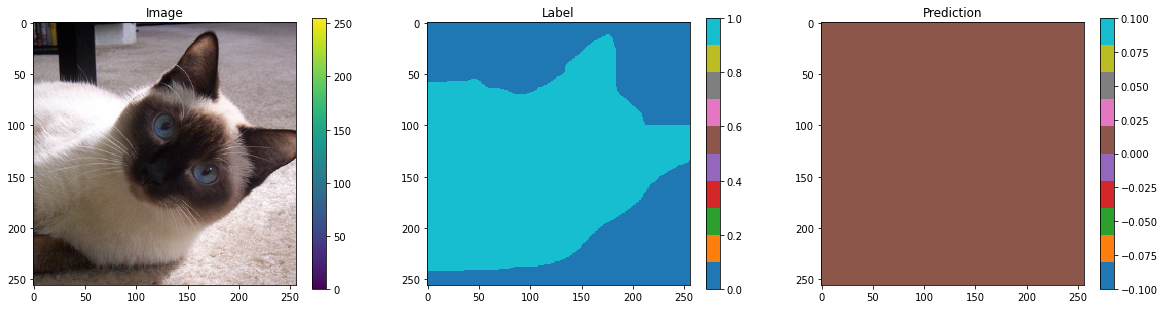

torch.float32
tensor(65115., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(38106., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.3950, device='cuda:0', grad_fn=<RsubBackward1>)


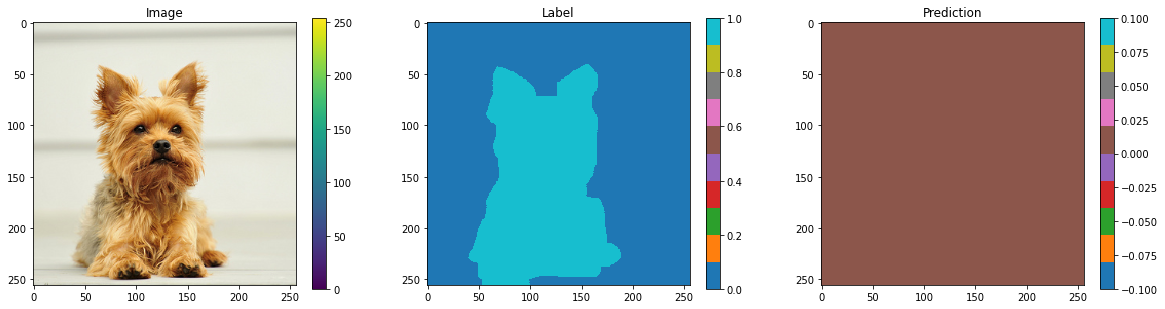

torch.float32
tensor(64705., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(21536., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.2406, device='cuda:0', grad_fn=<RsubBackward1>)


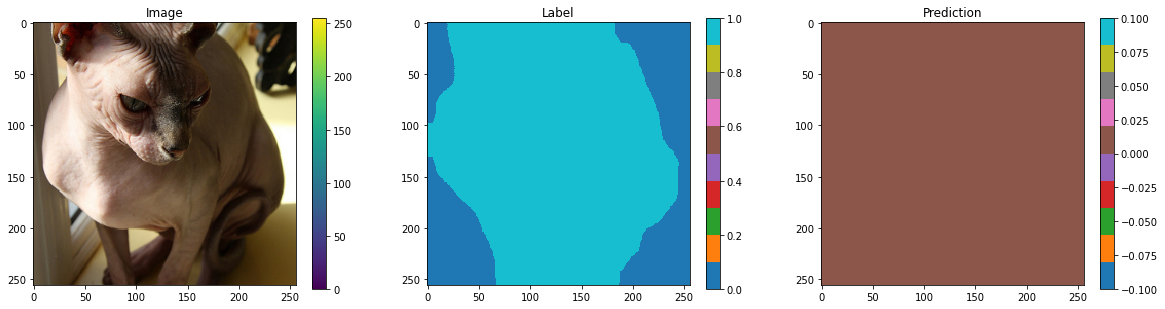

torch.float32
tensor(49251., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(48389., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.3949, device='cuda:0', grad_fn=<RsubBackward1>)


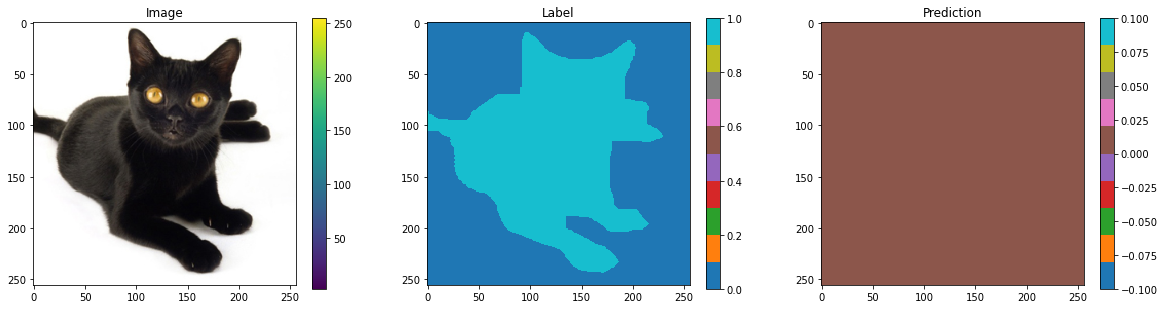

torch.float32
tensor(65026., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(26709., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.4330, device='cuda:0', grad_fn=<RsubBackward1>)


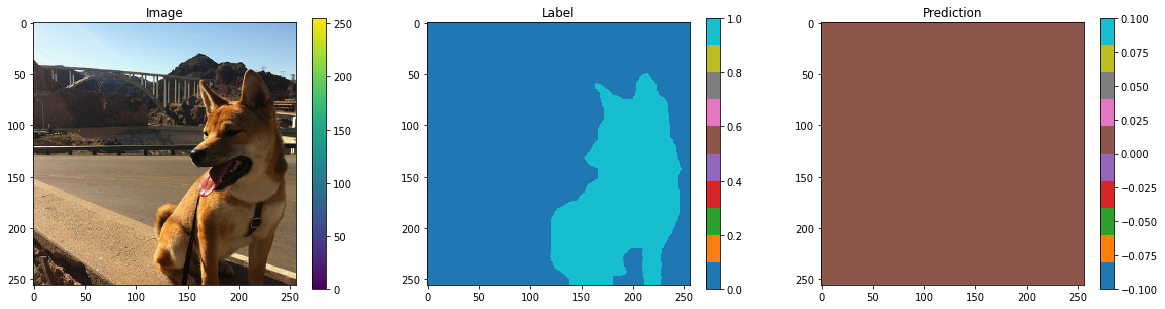

torch.float32
tensor(48953., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(16705., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.4337, device='cuda:0', grad_fn=<RsubBackward1>)


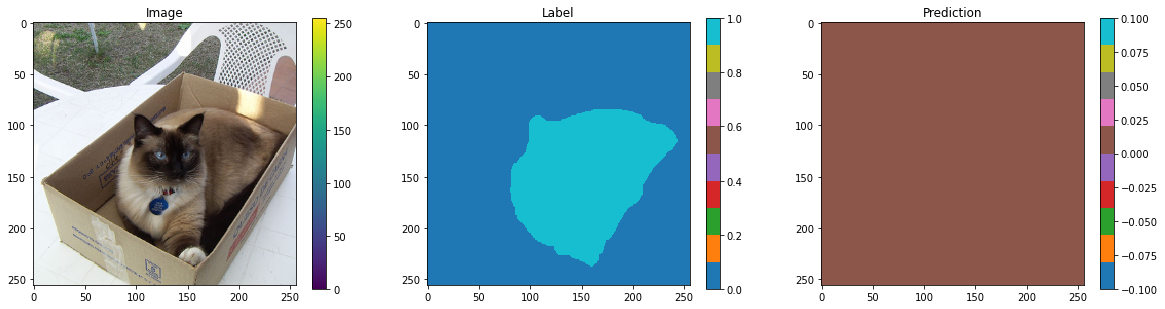

torch.float32
tensor(1688., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(15966., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.8360, device='cuda:0', grad_fn=<RsubBackward1>)


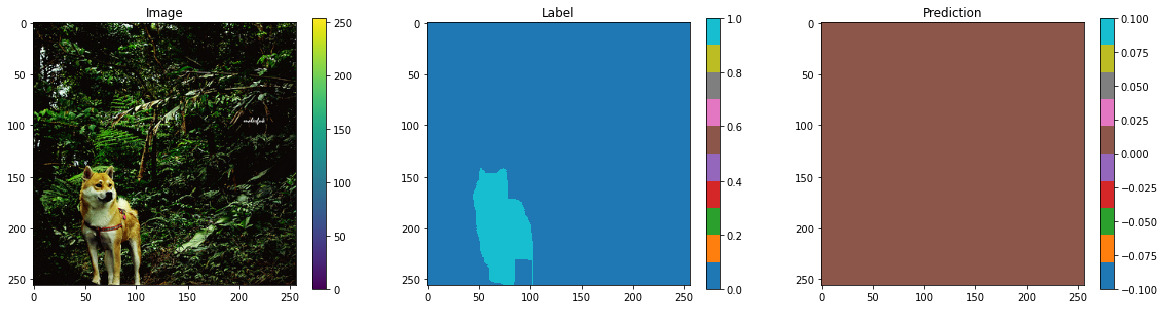

torch.float32
tensor(6812., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(4410., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.5869, device='cuda:0', grad_fn=<RsubBackward1>)


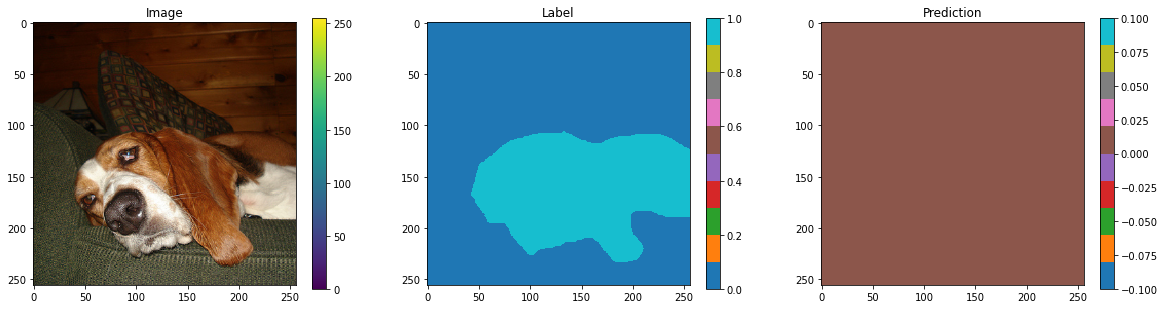

torch.float32
tensor(28230., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(19458., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.5202, device='cuda:0', grad_fn=<RsubBackward1>)


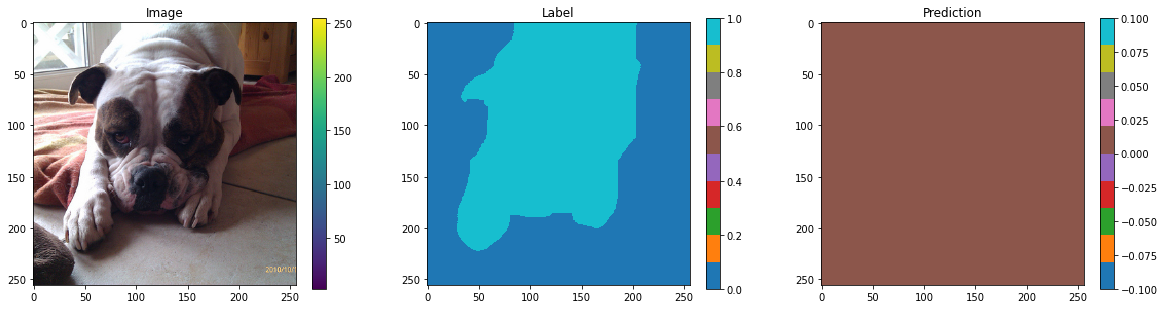

torch.float32
tensor(6811., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(28867., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.4338, device='cuda:0', grad_fn=<RsubBackward1>)


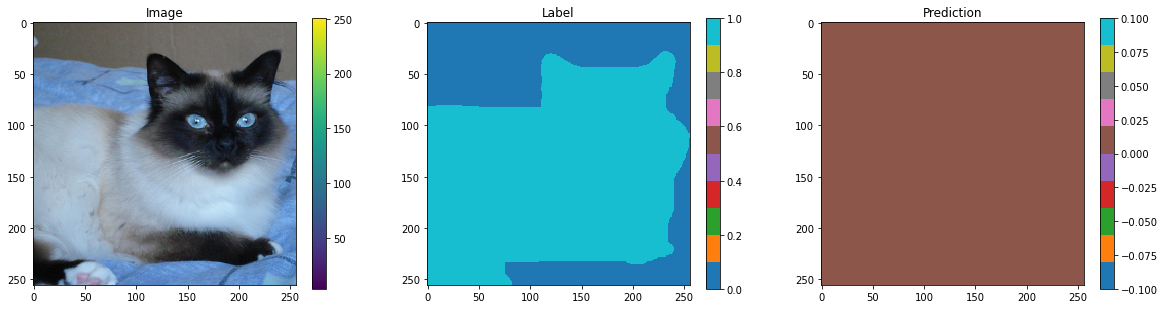

torch.float32
tensor(292., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(43815., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.1880, device='cuda:0', grad_fn=<RsubBackward1>)


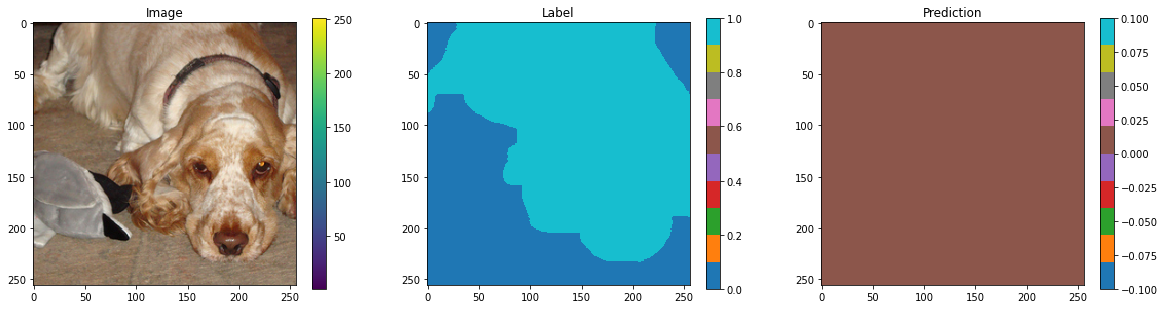

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(41208., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.1119, device='cuda:0', grad_fn=<RsubBackward1>)


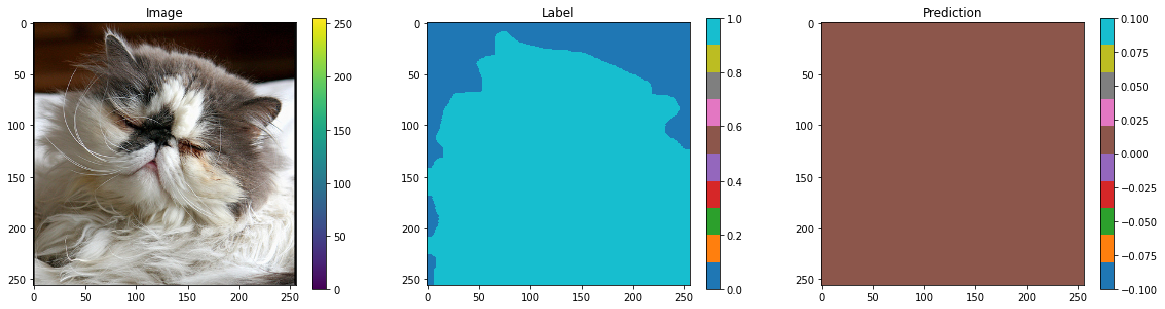

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(51526., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.4198, device='cuda:0', grad_fn=<RsubBackward1>)


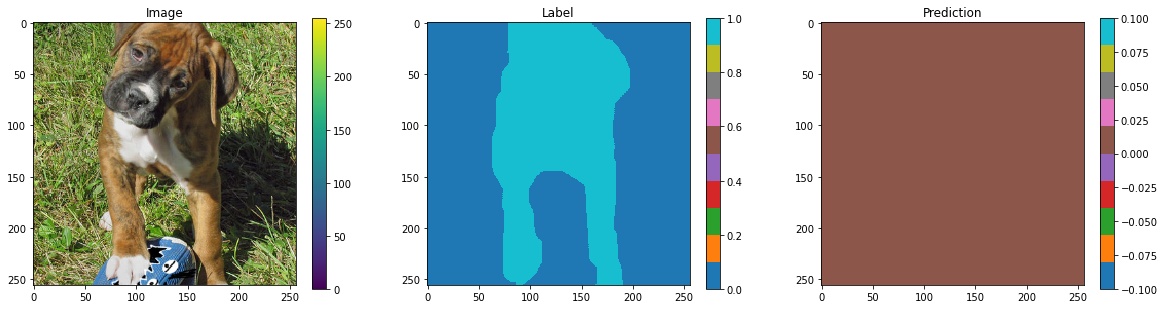

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(23274., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.3232, device='cuda:0', grad_fn=<RsubBackward1>)


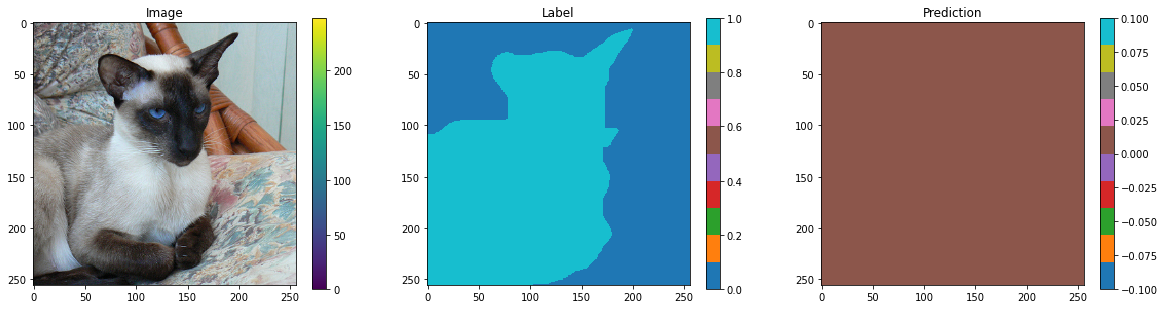

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(34328., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.2902, device='cuda:0', grad_fn=<RsubBackward1>)


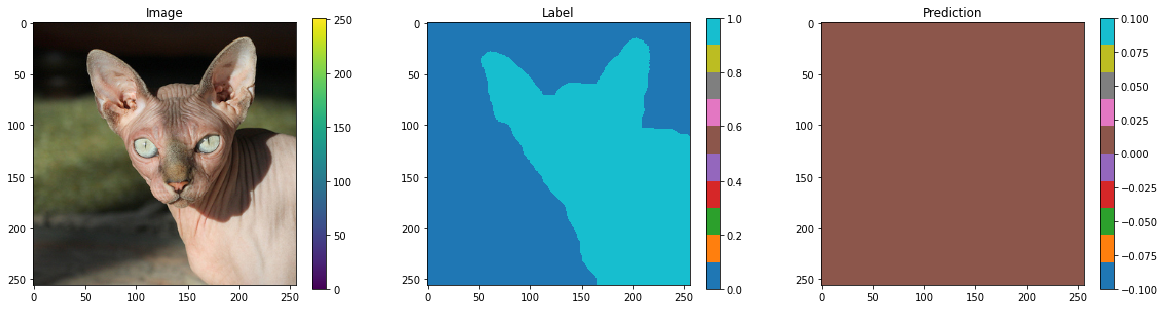

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(28340., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.4763, device='cuda:0', grad_fn=<RsubBackward1>)


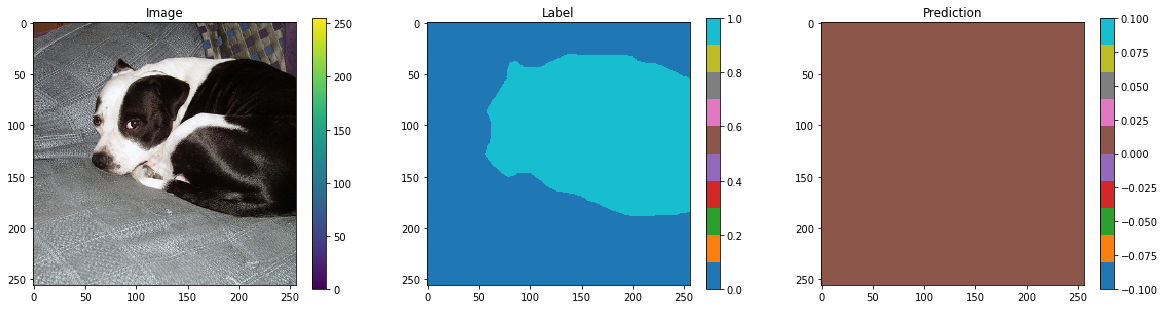

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(25415., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.1312, device='cuda:0', grad_fn=<RsubBackward1>)


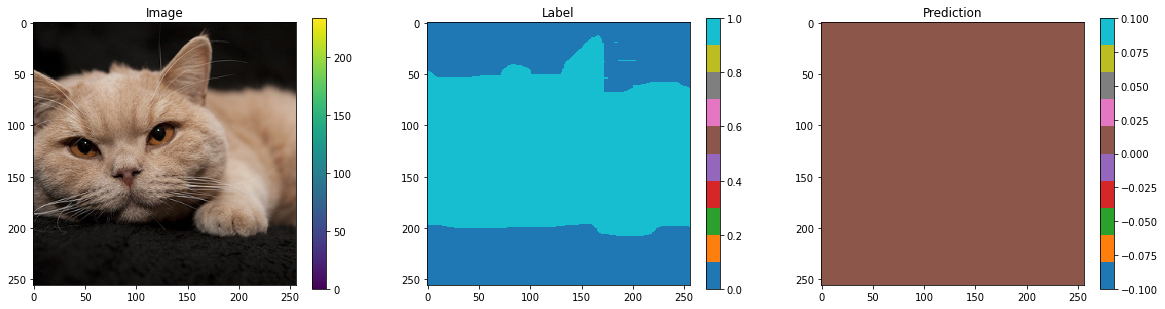

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(38692., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.1440, device='cuda:0', grad_fn=<RsubBackward1>)


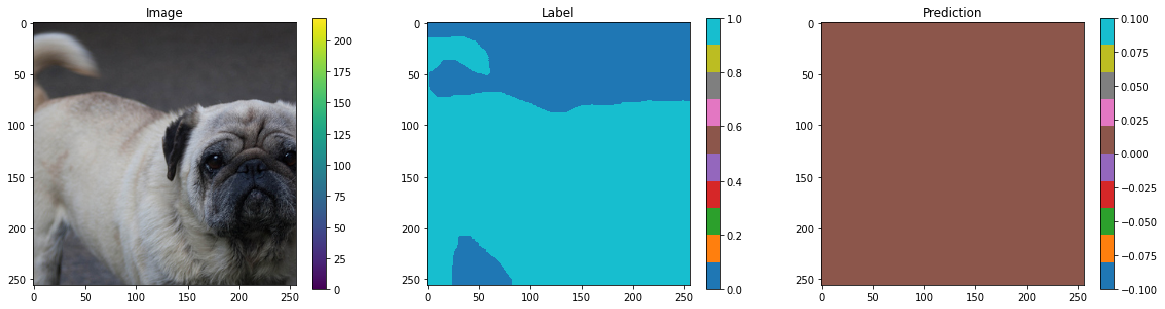

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(45580., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.6888, device='cuda:0', grad_fn=<RsubBackward1>)


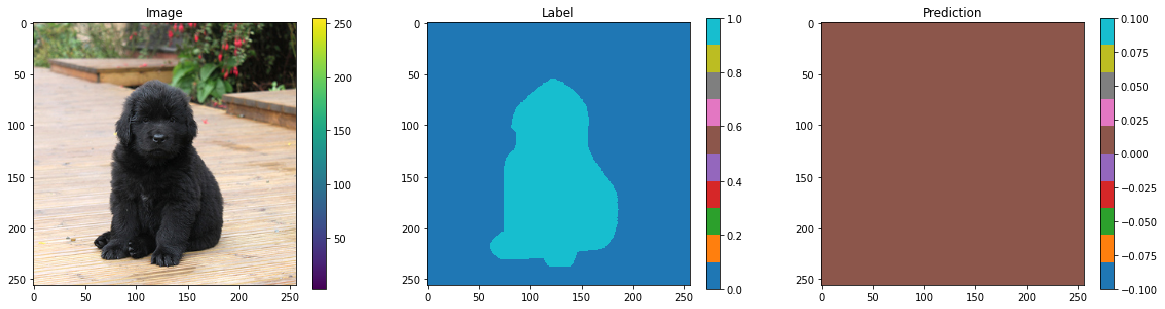

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(15205., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.8695, device='cuda:0', grad_fn=<RsubBackward1>)


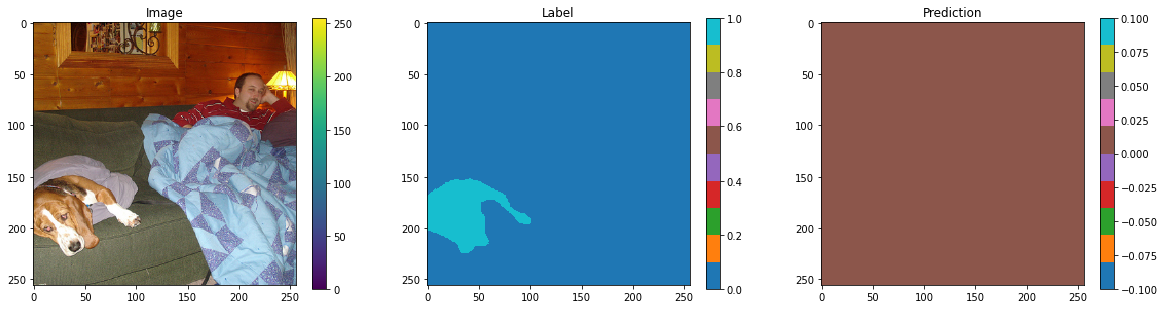

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(3694., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.1067, device='cuda:0', grad_fn=<RsubBackward1>)


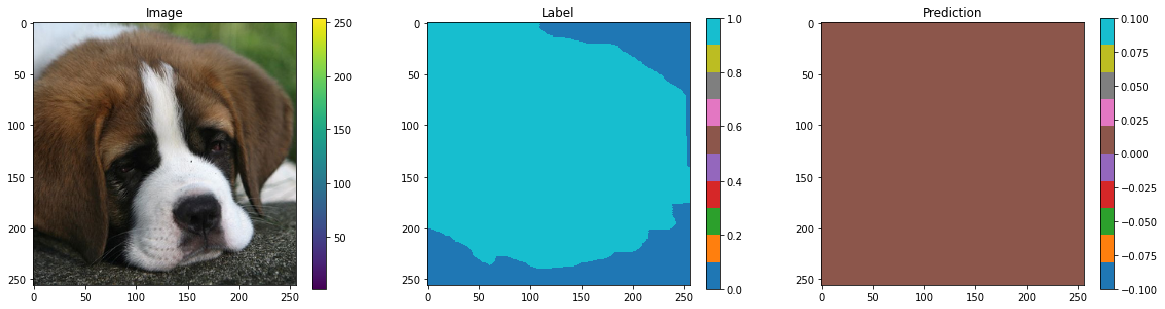

torch.float32
tensor(65536., device='cuda:0', grad_fn=<SumBackward0>)
torch.float32
tensor(51742., device='cuda:0')
yhat dtype: torch.float32
y dtype: torch.float32
tensor(0.5950, device='cuda:0', grad_fn=<RsubBackward1>)


KeyboardInterrupt: 

In [12]:
slite.run_exp(
    config=cfgs[0], 
    exp_class=CalibrationExperiment,
    gpu='3'
)

In [ ]:
# Submit the experiments
# slite.submit_exps(
#     project="ESE",
#     exp_name=exp_name,
#     exp_class=CalibrationExperiment,
#     available_gpus=['0', '1', '2', '3'],
#     config_list=cfgs
# )